In [76]:
# SENTIMENT ANALYSIS OF AMAZON CUSTOMER FEEDBACK
# Using NLP + Machine Learning

# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [51]:
# --- 2. Load Dataset ---
df = pd.read_csv("amazon_reviews.csv") 

def rating_to_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment"] = df["overall"].apply(rating_to_sentiment)

print(df[["overall", "sentiment"]].head())

   overall sentiment
0        5  positive
1        1  negative
2        3   neutral
3        2  negative
4        1  negative


In [52]:
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,sentiment
0,0,528881469,"[0, 0]",5,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200,positive
1,1,528881469,"[12, 15]",1,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200,negative
2,2,528881469,"[43, 45]",3,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400,neutral
3,3,528881469,"[9, 10]",2,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800,negative
4,4,528881469,"[0, 0]",1,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400,negative


In [53]:
df.shape

(999, 11)

In [54]:
import re
import string
from collections import Counter
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

# --- Step 1: Basic lowercase & cleanup for frequency counting ---
def basic_clean(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text.strip()

df["temp_text"] = df["reviewText"].apply(basic_clean)

# --- Step 2: Count word frequencies ---
all_words = [word for text in df["temp_text"] for word in text.split() if word not in stop_words]
word_freq = Counter(all_words)

threshold = 500  
high_freq_words = {word for word, freq in word_freq.items() if freq > threshold}

print(f"High frequency words to remove: {list(high_freq_words)[:20]}")  

# --- Step 3: Final clean function ---
def clean_text(text, high_freq_words):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words and word not in high_freq_words]
    return " ".join(words)

df["clean_review"] = df["reviewText"].apply(lambda x: clean_text(x, high_freq_words))

# Drop temp column
df.drop(columns=["temp_text"], inplace=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Assurex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


High frequency words to remove: ['nook', 'one', 'books', 'kindle']


In [55]:
df.shape

(999, 12)

In [56]:
df["helpful"] = df["helpful"].apply(ast.literal_eval)
# Split into two columns
df["helpful_votes"] = df["helpful"].apply(lambda x: x[0])
df["total_votes"] = df["helpful"].apply(lambda x: x[1])
# Drop the original 'helpful' column
df.drop(columns=["helpful"], inplace=True)
df.head()

,Unnamed: 0,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,sentiment,clean_review,helpful_votes,total_votes
0,0,528881469,5,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200,positive,got gps husband otr road trucker impressed shi...,0,0
1,1,528881469,1,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200,negative,im professional otr truck driver bought tnd tr...,12,15
2,2,528881469,3,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400,neutral,well say ive unit truck four days prior garmin...,43,45
3,3,528881469,2,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800,negative,going write long review even thought unit dese...,9,10
4,4,528881469,1,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400,negative,ive mine year heres got tries route non truck ...,0,0


### Sentiment Class Distribution

C:\Users\Assurex\AppData\Local\Temp\ipykernel_4056\1692630122.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


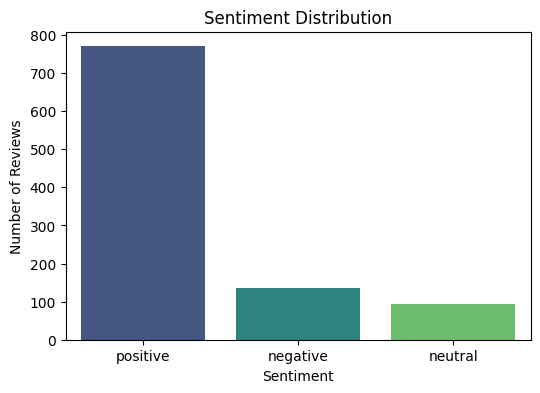

In [67]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

### Review Length Distribution

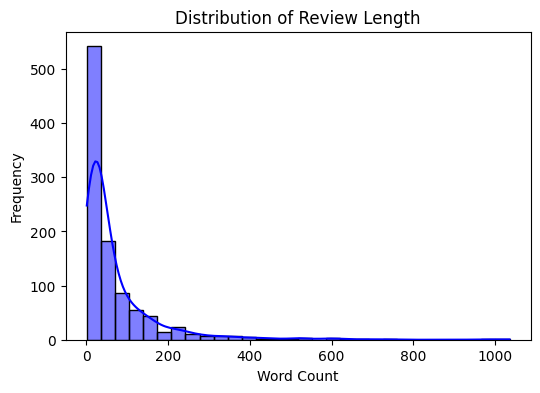

sentiment
negative    101.748148
neutral      94.138298
positive     61.145455
Name: review_length, dtype: float64

In [68]:
df['review_length'] = df['clean_review'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
sns.histplot(df['review_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Review Length')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()
df.groupby('sentiment')['review_length'].mean()

### Most Common Words per Sentiment

In [69]:
from collections import Counter

def top_n_words(texts, n=10):
    all_words = " ".join(texts).split()
    return Counter(all_words).most_common(n)

for sentiment in df['sentiment'].unique():
    top_words = top_n_words(df[df['sentiment'] == sentiment]['clean_review'])
    print(f"\nTop words for sentiment '{sentiment}':")
    for word, freq in top_words:
        print(f"{word}: {freq}")


Top words for sentiment 'positive':
great: 368
screen: 327
tv: 325
like: 325
use: 300
read: 291
get: 264
good: 260
would: 252
tablet: 251

Top words for sentiment 'negative':
bn: 95
get: 87
would: 78
read: 78
use: 76
book: 76
device: 72
even: 71
screen: 70
buy: 69

Top words for sentiment 'neutral':
screen: 78
read: 65
like: 61
device: 54
reading: 50
bn: 49
would: 48
use: 45
tablet: 44
color: 43


### Wordcloud

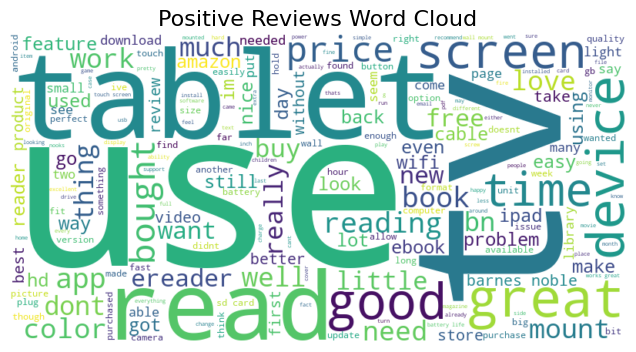

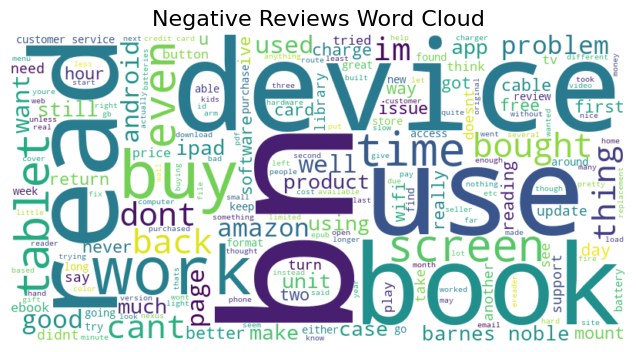

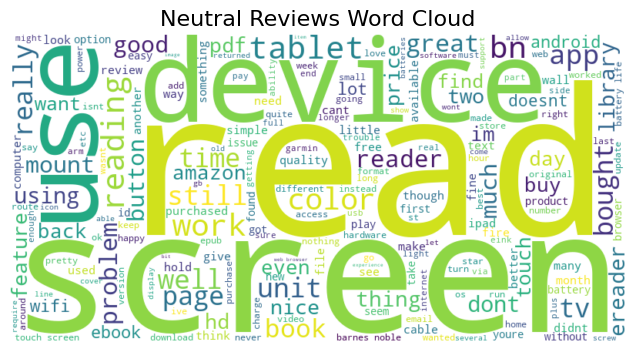

In [71]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Positive
plot_wordcloud(df[df['sentiment'] == 'positive']['clean_review'], 'Positive Reviews Word Cloud')

# Negative
plot_wordcloud(df[df['sentiment'] == 'negative']['clean_review'], 'Negative Reviews Word Cloud')

# Neutral
plot_wordcloud(df[df['sentiment'] == 'neutral']['clean_review'], 'Neutral Reviews Word Cloud')

(999, 13)

In [58]:
def all_votes_valid(df):
    return (df["total_votes"] >= df["helpful_votes"]).all()

if all_votes_valid(df):
    print("All rows have total_votes >= helpful_votes.")
else:
    print("Some rows have total_votes < helpful_votes.")

All rows have total_votes >= helpful_votes.


In [59]:
df.shape

(999, 13)

In [61]:
df.head()

,Unnamed: 0,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,sentiment,clean_review,helpful_votes,total_votes
0,0,528881469,5,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200,positive,got gps husband otr road trucker impressed shi...,0,0
1,1,528881469,1,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200,negative,im professional otr truck driver bought tnd tr...,12,15
2,2,528881469,3,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400,neutral,well say ive unit truck four days prior garmin...,43,45
3,3,528881469,2,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800,negative,going write long review even thought unit dese...,9,10
4,4,528881469,1,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400,negative,ive mine year heres got tries route non truck ...,0,0


Tuning Logistic Regression with cv=75...


<Figure size 600x400 with 0 Axes>

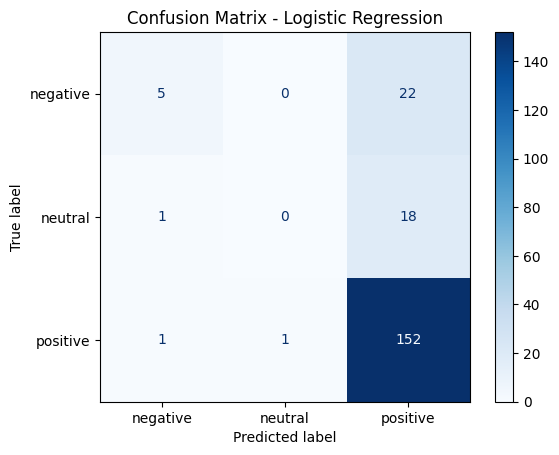

Tuning Linear SVM with cv=75...


<Figure size 600x400 with 0 Axes>

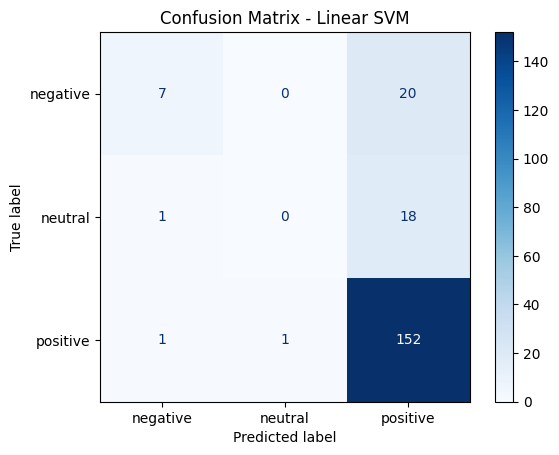

Tuning Naive Bayes with cv=75...


<Figure size 600x400 with 0 Axes>

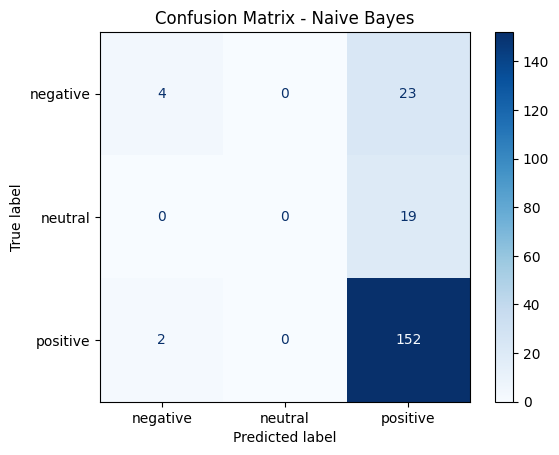

Tuning Random Forest with cv=75...


<Figure size 600x400 with 0 Axes>

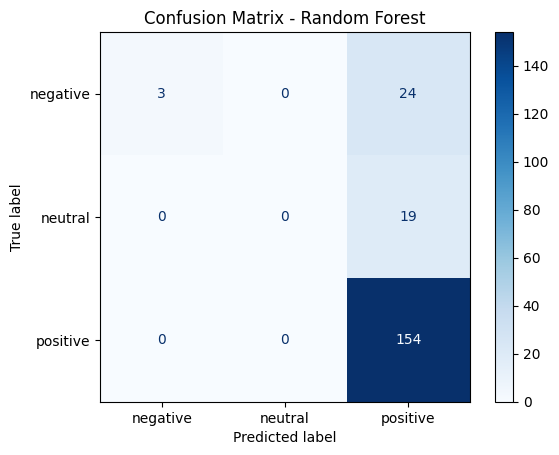

,Model,Best Params,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,"{'clf__C': 10, 'tfidf__ngram_range': (1, 1)}",0.785,0.706012,0.785,0.716238
1,Linear SVM,"{'clf__C': 1, 'tfidf__ngram_range': (1, 1)}",0.795,0.721000,0.795,0.732965
2,Naive Bayes,"{'clf__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}",0.780,0.693299,0.780,0.705371
3,Random Forest,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.785,0.736929,0.785,0.702670


In [81]:
from sklearn.metrics import ConfusionMatrixDisplay

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_review"], df["sentiment"],
    test_size=0.2, random_state=42, stratify=df["sentiment"]
)

min_class_size = y_train.value_counts().min()
cv_splits = max(2, min_class_size)

# Define pipelines
pipelines = {
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    "Linear SVM": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LinearSVC())
    ]),
    "Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ]),
    "Random Forest": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', RandomForestClassifier(random_state=42))
    ])
}

# Parameter grids
param_grids = {
    "Logistic Regression": {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.1, 1, 10]
    },
    "Linear SVM": {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.1, 1, 10]
    },
    "Naive Bayes": {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__alpha': [0.1, 1, 10]
    },
    "Random Forest": {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5]
    }
}

results = []

# Grid search for each model
for name in pipelines.keys():
    print(f"Tuning {name} with cv={cv_splits}...")
    grid = GridSearchCV(
        pipelines[name],
        param_grids[name],
        cv=cv_splits,
        scoring='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # Store results
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
    plt.figure(figsize=(6, 4))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Show all model evaluation results
results_df = pd.DataFrame(results)
display(results_df)